In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
%matplotlib inline
sns.set(style="darkgrid" )

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
prob = pd.read_csv('ClassificationProblem1.txt', delimiter = '\t', index_col = 'Index', parse_dates = ['F15', 'F16'])
prob['F23']=(prob.F15-prob.F16).astype('timedelta64[D]')
prob_data = prob.drop(['F15', 'F16', 'C'], axis = 1)
scaler = MinMaxScaler(feature_range=(-1,1))
prob_data_scaled = pd.DataFrame(scaler.fit_transform(prob_data), columns=prob_data.columns)
prob_data_final = prob_data_scaled.drop(['F21', 'F22', 'F18', 'F17'], axis = 1)
X = prob_data_final.values
y = prob.C.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [22]:
n_range = range(10,401,10)
learning_rate_options = [0.1, 0.2, 0.5]
params_grid = dict(n_estimators=n_range, learning_rate = learning_rate_options)
print params_grid

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400], 'learning_rate': [0.1, 0.2, 0.5]}


In [23]:
Adbc = AdaBoostClassifier()
grid = GridSearchCV(Adbc, params_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400], 'learning_rate': [0.1, 0.2, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [24]:
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.689193425146
{'n_estimators': 190, 'learning_rate': 0.2}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=190, random_state=None)


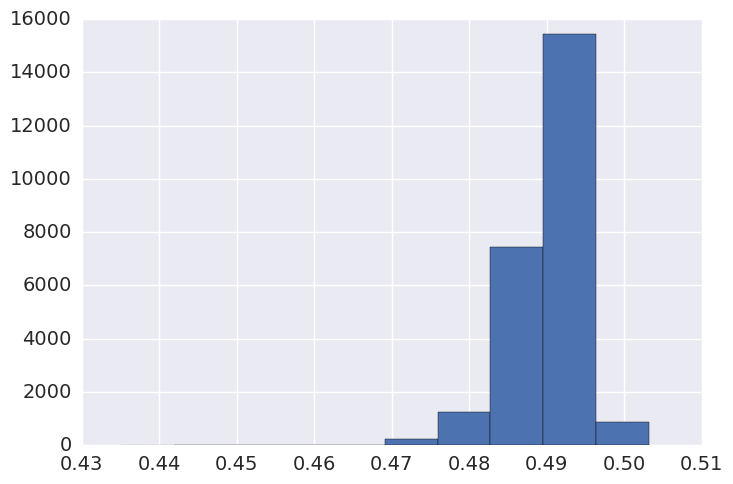

In [25]:
y_pred_adbc1 = grid.predict_proba(X_test)[:,1]
y_pred_adbc1 = pd.Series(y_pred_adbc1)
y_pred_adbc1.hist()

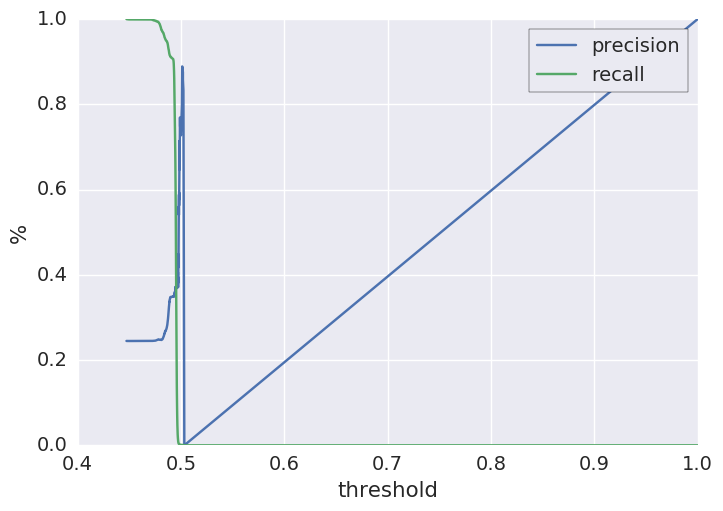

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_adbc1)  
thresholds = np.append(thresholds, 1)

plt.plot(thresholds, precision, color=sns.color_palette()[0],  )  
plt.plot(thresholds, recall, color=sns.color_palette()[1])

leg = plt.legend(('precision', 'recall'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')
plt.ylabel('%')
plt.savefig('precion-recall-curve-adbc_190_0.2.jpg')

In [27]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_adbc1)
roc_auc = auc(false_positive_rate, true_positive_rate)

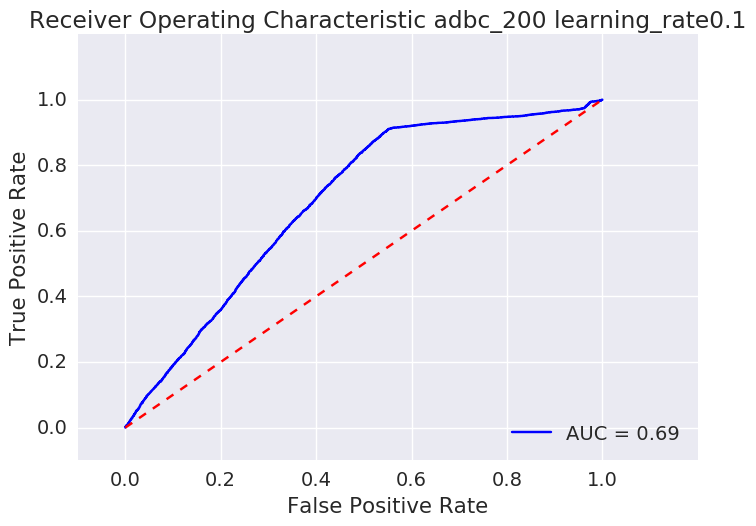

In [29]:
plt.title('Receiver Operating Characteristic adbc_200 learning_rate0.1')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Adaboost_190_learning_rate0.2_roc_curve.jpg')

0.494


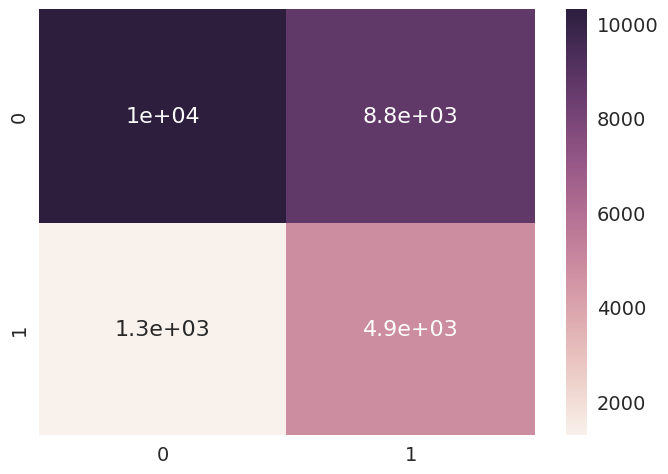

In [41]:
T = float(raw_input())
y_pred_adbc1 = pd.Series(y_pred_adbc1)
pred_test = y_pred_adbc1.map(lambda x: 0 if x<T else 1)
cnf_matrix = confusion_matrix(y_test, pred_test)
df_cm= pd.DataFrame(cnf_matrix, [0,1], [0,1])
g = sns.set(font_scale=1.4)
g = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
fig =g.get_figure()
fig.savefig('confusion_matrix_adbc_t_'+str(T)+'.jpg')